# Imbalanced Data
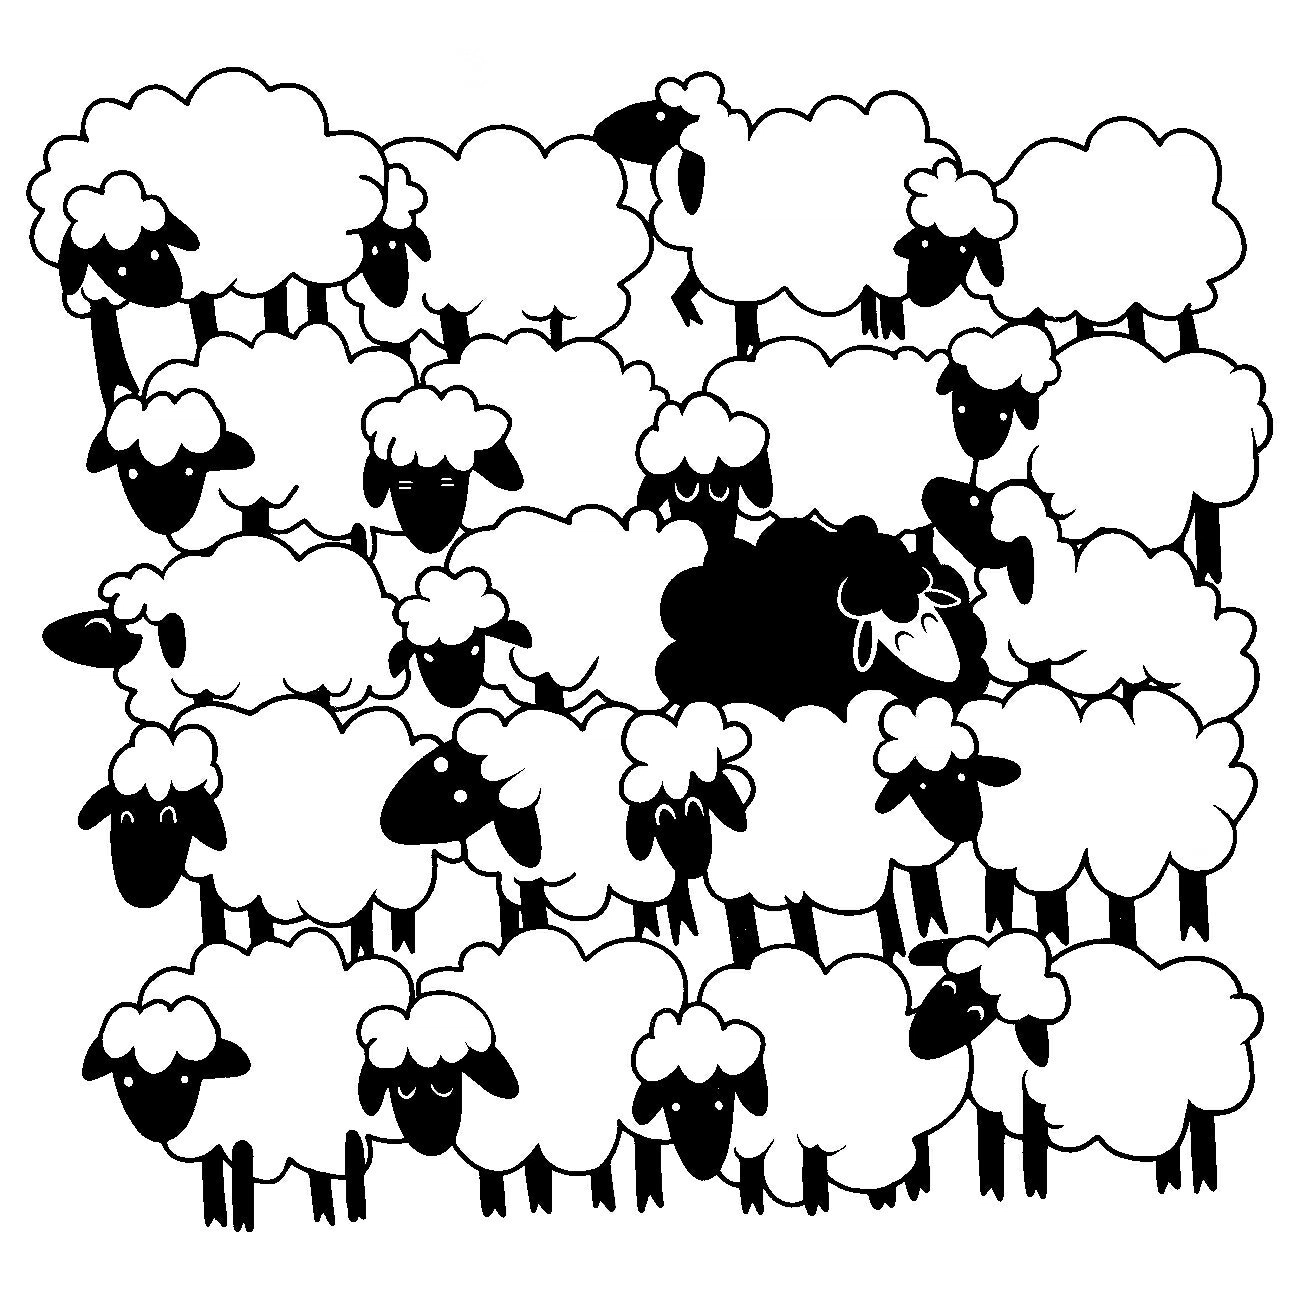

# Setup
We're using standard python data tools and the imbalanced-learn contrib toolkit.  The notebook includes analysis and techniques presented across multiple sources and where possible, is labeled with a link to the underlying paper, code or technique.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.metrics import classification_report_imbalanced

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

# Create Dataset

## Helper Functions
https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html

In [2]:
def create_dataset(n_samples=1000, weights=(0.02, 0.98), n_classes=2, class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

## Confusion Matrix & Evaluation Metrics
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [4]:
def confusion(technique, df, yHat, y):
    confusionMatrix = confusion_matrix(y, yHat)
    classReport = classification_report_imbalanced(y, yHat)
    majPrecision = confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0])
    majRecall    = confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1])
    minPrecision = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[0][1])
    minRecall    = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[1][0])
    df.loc[technique] = [majPrecision, majRecall, minPrecision, minRecall]
    print(confusionMatrix)
    print(classReport)
    return confusionMatrix, classReport, (majPrecision, majRecall), (minPrecision, minRecall)

# Imbalanced Data

## Sample Plots with Different Class Weights
* Generating function with weights, class separation and data points
* Use a SVM for fitting a decision boundary

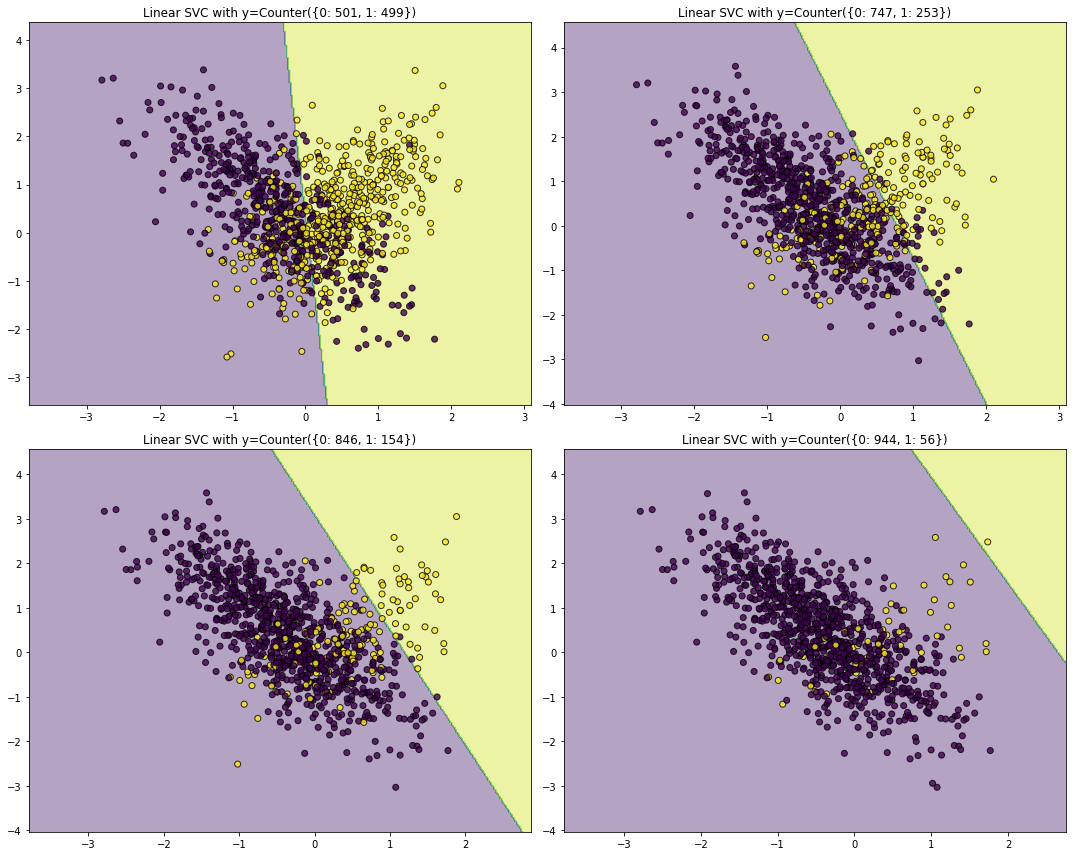

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.5, 0.5), (0.75, 0.25), (0.85, 0.15), (0.95, 0.05))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights, class_sep=0.4)
    pipe = make_pipeline(LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))
fig.tight_layout()

## Imbalanced Metrics
https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
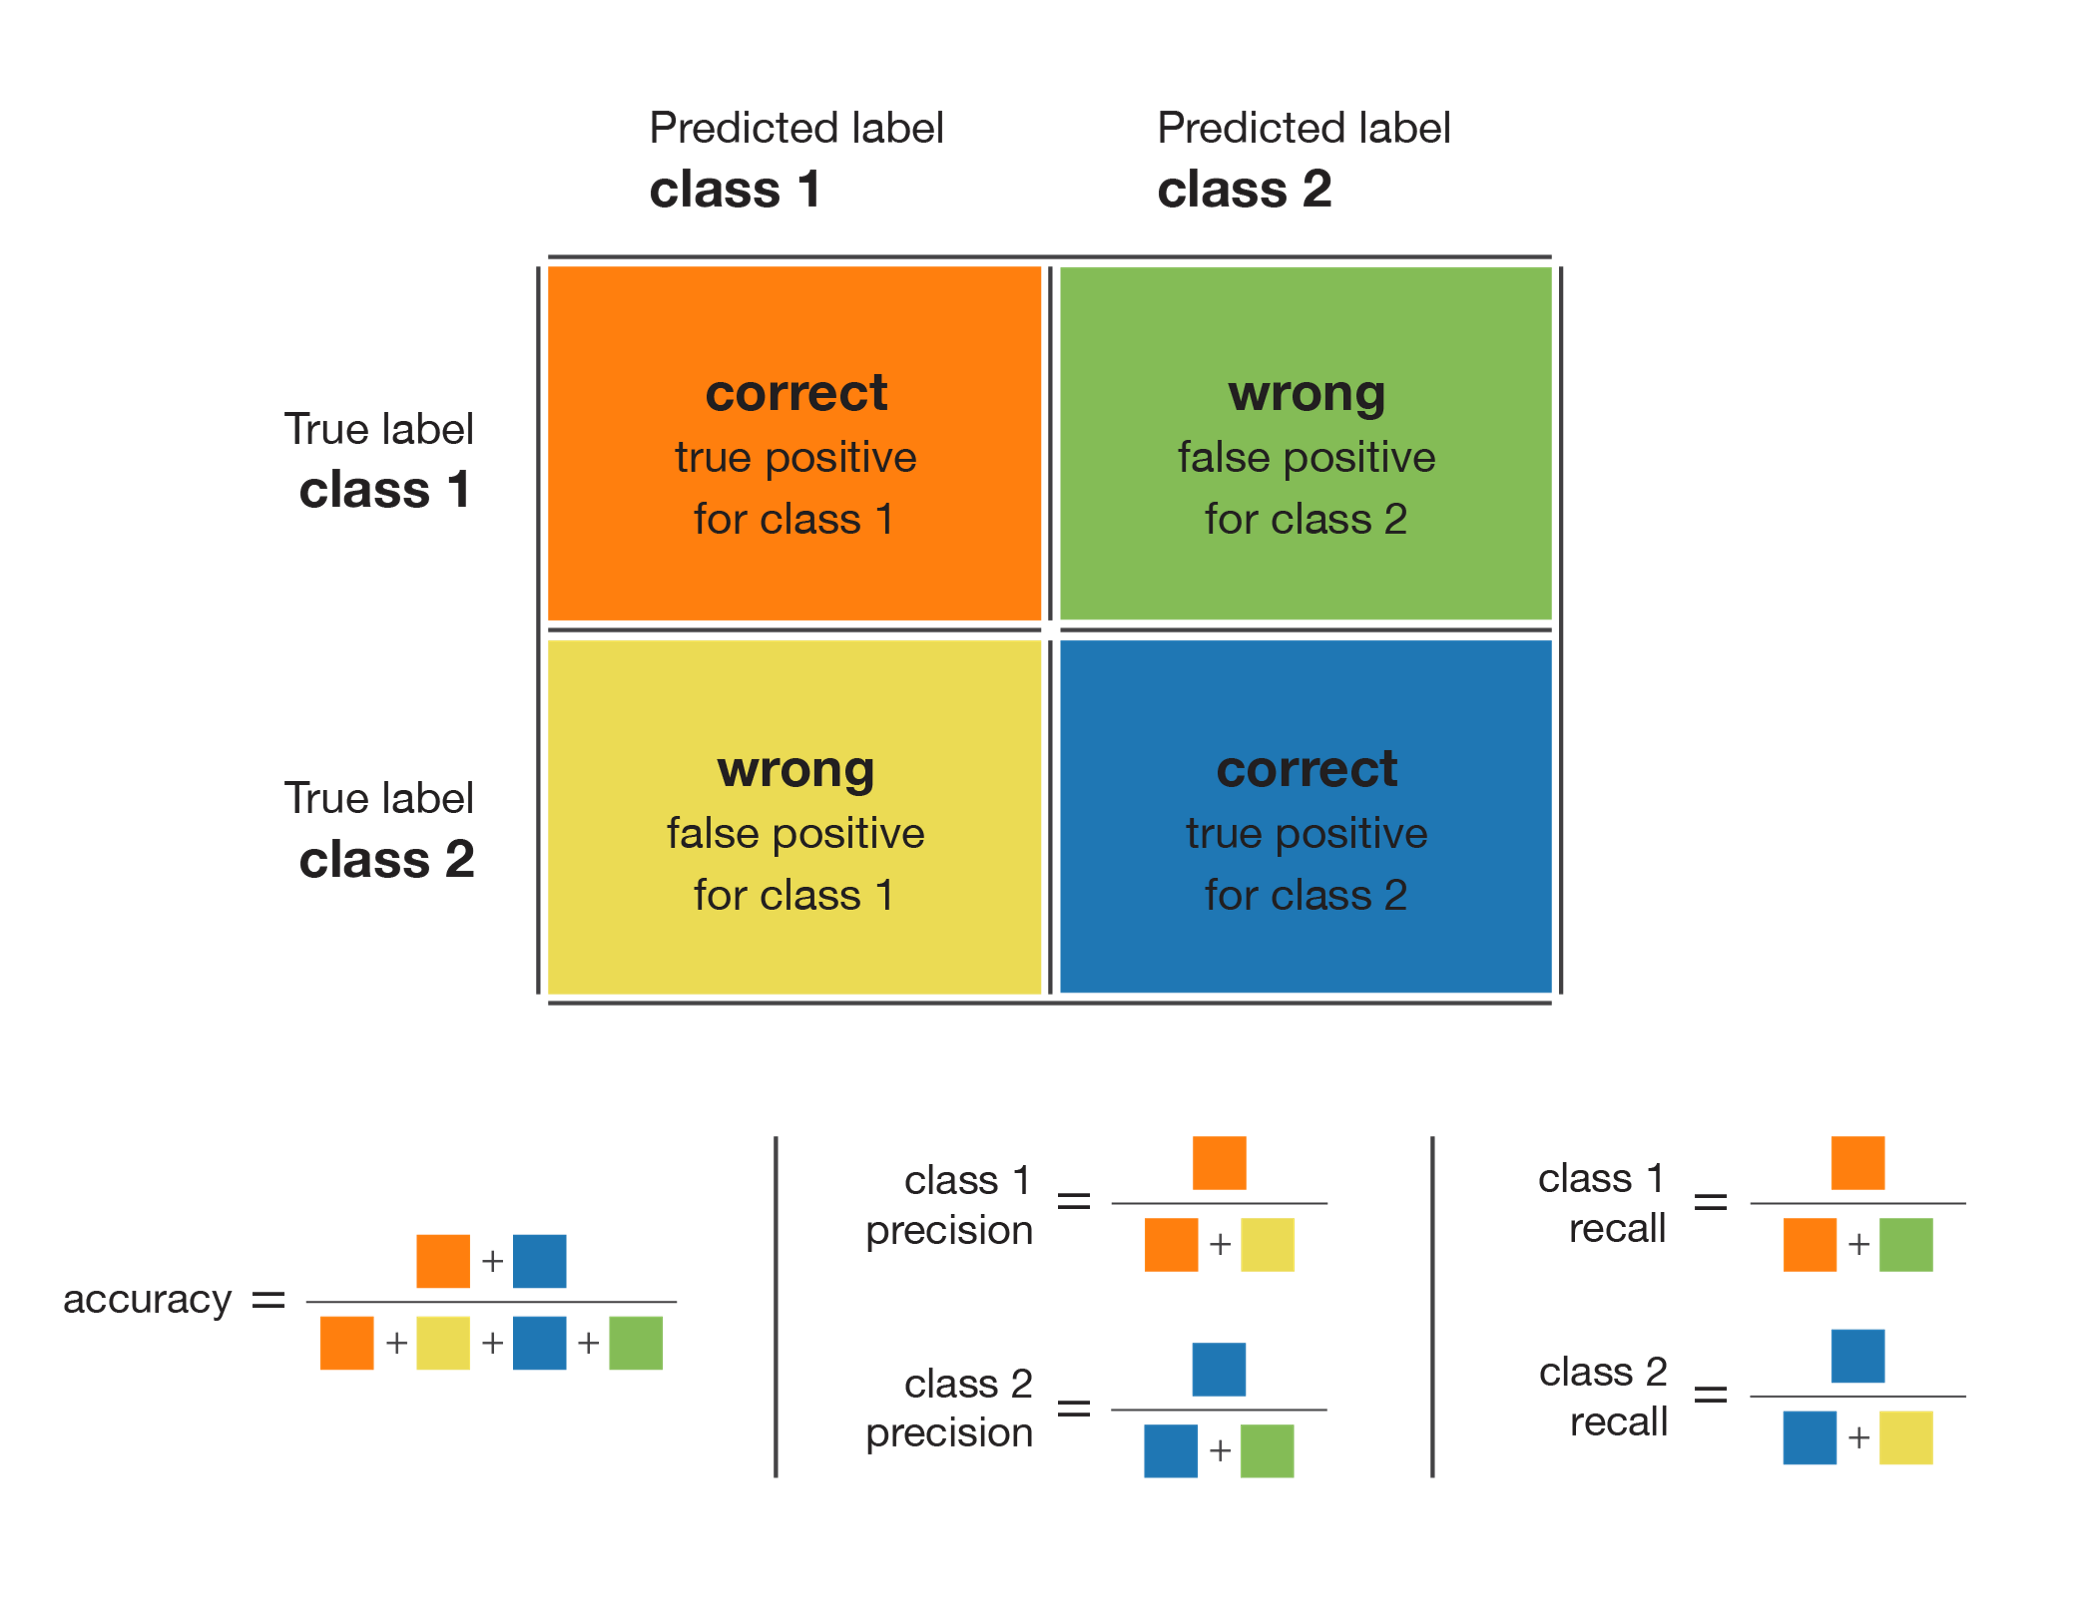

## Tracking Data Frame

* We want a high precision on our positive class.  Precision indicates the finding **only** the data that were actually positive.
* We want a high recall on our minority class.  Recall indicates the ability to find **all** the relevant data points.
* F1 Score = Harmonic Mean of Precision and Recall
* Geometric Mean (Geo) = Balanced Accuracy
* Index Balanced Accuracy (IBA) = Balanced Accuracy

In [6]:
# Keep a summary of how well different techniques work
resultsDF = pd.DataFrame(columns=['Maj Precision', 'Maj Recall', 'Min Precision', 'Min Recall'])

## Baseline
* Our baseline will be a 20X majority class with 1000 samples.
* Classifiers appear "lazy" as they favor the majority class.  See below (SVM on 20-1 Dataset)
* As we try evaluate techniques we'll measure precision and recall.

Text(0.5, 1.0, 'Linear SVC with y=Counter({0: 944, 1: 56})')

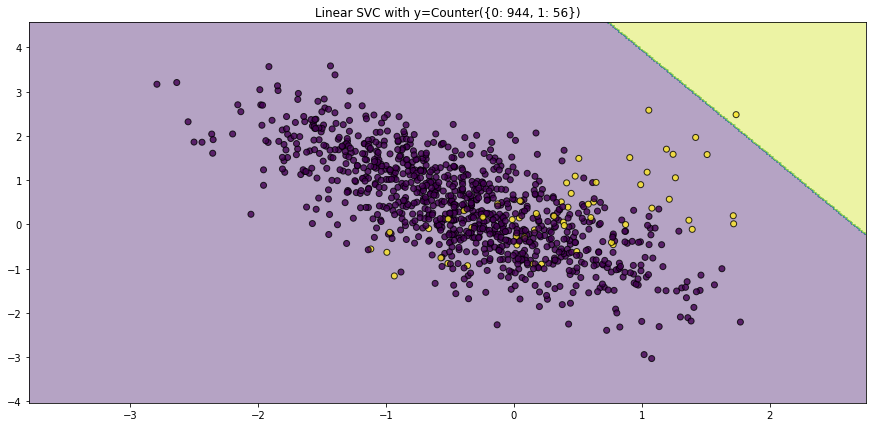

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
X, y = create_dataset(n_samples=1000, weights=(0.95, 0.05), class_sep=0.4)
pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

In [8]:
con, cr, majority, minority = confusion('Baseline', resultsDF, pipe.predict(X), y)
resultsDF

[[944   0]
 [ 55   1]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.02      0.97      0.13      0.02       944
          1       1.00      0.02      1.00      0.04      0.13      0.02        56

avg / total       0.95      0.94      0.07      0.92      0.13      0.02      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline       0.944945         1.0            1.0    0.017857

# Over Sampling
Achieve balance by increasing the number of minority classes which reduces the imbalance ratio.

## Random Sampling

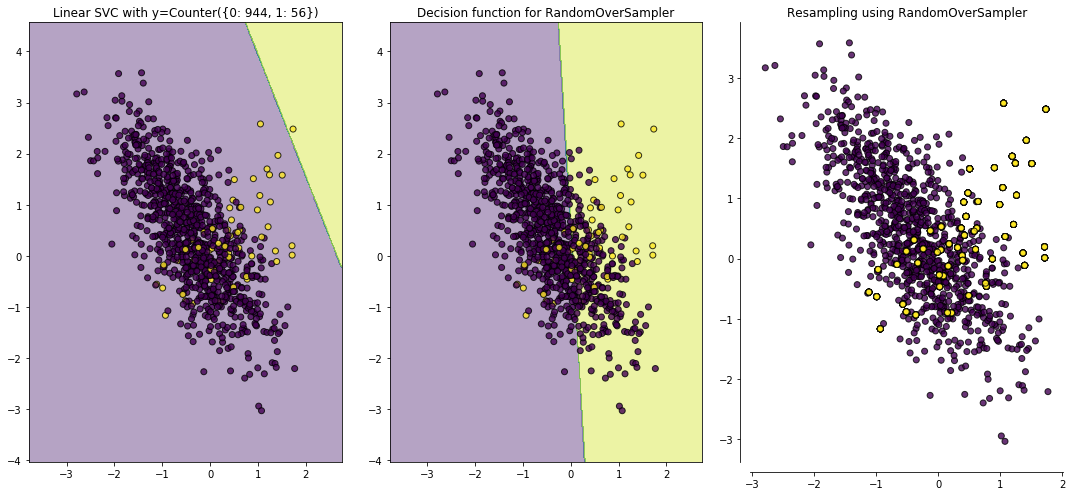

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(RandomOverSampler(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for RandomOverSampler')

plot_resampling(X, y, RandomOverSampler(random_state=0), ax3)
ax3.set_title('Resampling using RandomOverSampler')
fig.tight_layout()

In [10]:
con, cr, majority, minority = confusion('Random Over Sampling', resultsDF, pipe.predict(X), y)
resultsDF

[[689 255]
 [ 16  40]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.73      0.71      0.84      0.72      0.52       944
          1       0.14      0.71      0.73      0.23      0.72      0.52        56

avg / total       0.93      0.73      0.72      0.80      0.72      0.52      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                   0.944945    1.000000       1.000000    0.017857
Random Over Sampling       0.977305    0.729873       0.135593    0.714286

## SMOTE
* Synthetic Minority Over Sampling Technique
* http://rikunert.com/SMOTE_explained


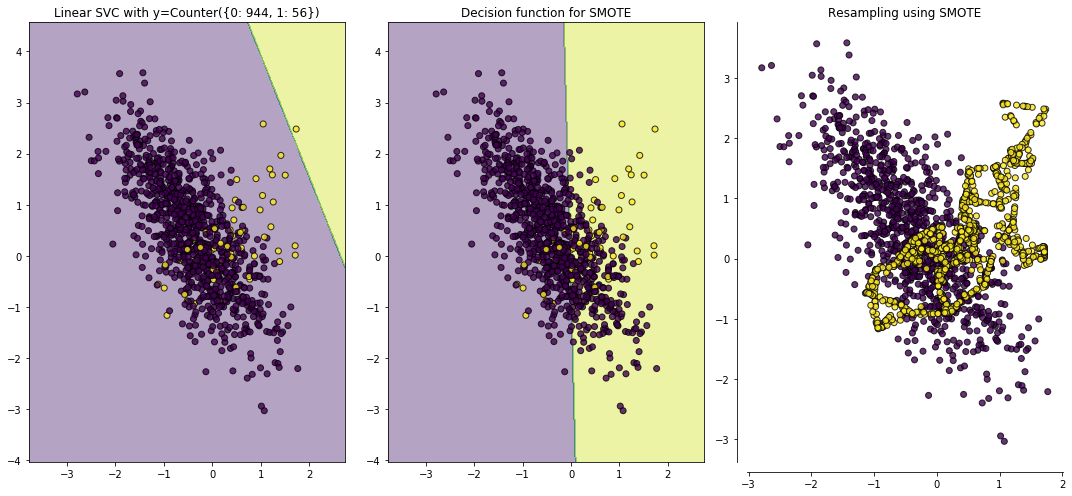

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(SMOTE(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for SMOTE')

plot_resampling(X, y, SMOTE(), ax3)
ax3.set_title('Resampling using SMOTE')
fig.tight_layout()

In [12]:
con, cr, prec, rec = confusion('SMOTE', resultsDF, pipe.predict(X), y)
resultsDF

[[665 279]
 [ 13  43]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.70      0.77      0.82      0.74      0.54       944
          1       0.13      0.77      0.70      0.23      0.74      0.54        56

avg / total       0.93      0.71      0.76      0.79      0.74      0.54      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                   0.944945    1.000000       1.000000    0.017857
Random Over Sampling       0.977305    0.729873       0.135593    0.714286
SMOTE                      0.980826    0.704449       0.133540    0.767857

## Borderline SMOTE
https://www.datasciencecentral.com/profiles/blogs/dealing-with-imbalanced-datasets
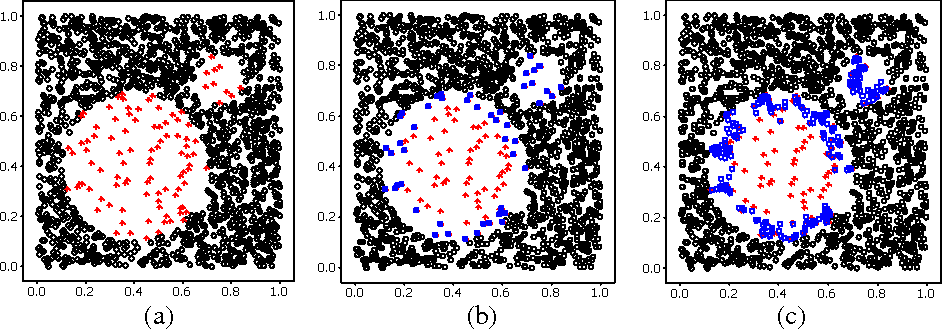

### Borderline SMOTE 1

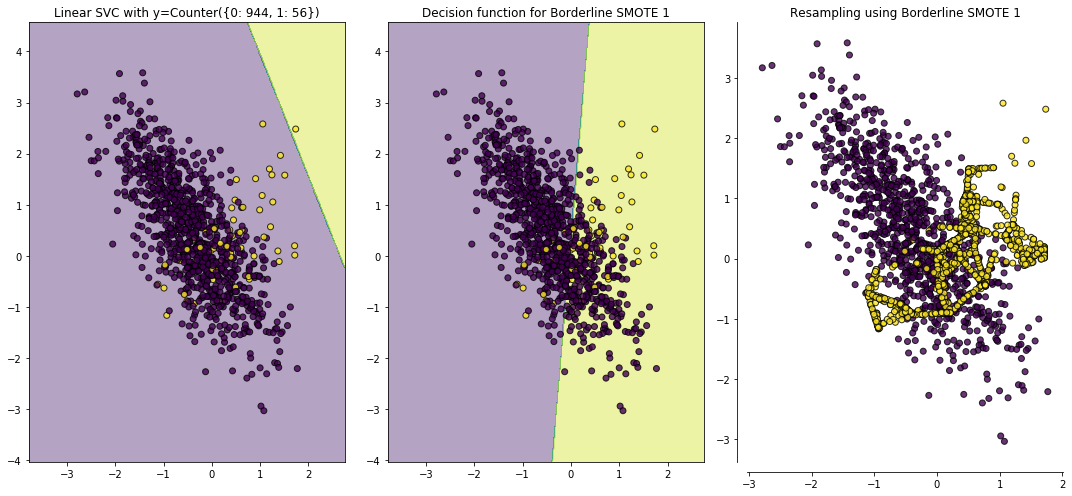

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(BorderlineSMOTE(random_state=0, kind='borderline-1'), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for Borderline SMOTE 1')

plot_resampling(X, y, BorderlineSMOTE(random_state=0, kind='borderline-1'), ax3)
ax3.set_title('Resampling using Borderline SMOTE 1')
fig.tight_layout()

In [14]:
con, cr, prec, rec = confusion('Borderline SMOTE 1', resultsDF, pipe.predict(X), y)
resultsDF

[[658 286]
 [ 13  43]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.70      0.77      0.81      0.73      0.53       944
          1       0.13      0.77      0.70      0.22      0.73      0.54        56

avg / total       0.93      0.70      0.76      0.78      0.73      0.53      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                   0.944945    1.000000       1.000000    0.017857
Random Over Sampling       0.977305    0.729873       0.135593    0.714286
SMOTE                      0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1         0.980626    0.697034       0.130699    0.767857

### Borderline SMOTE 2

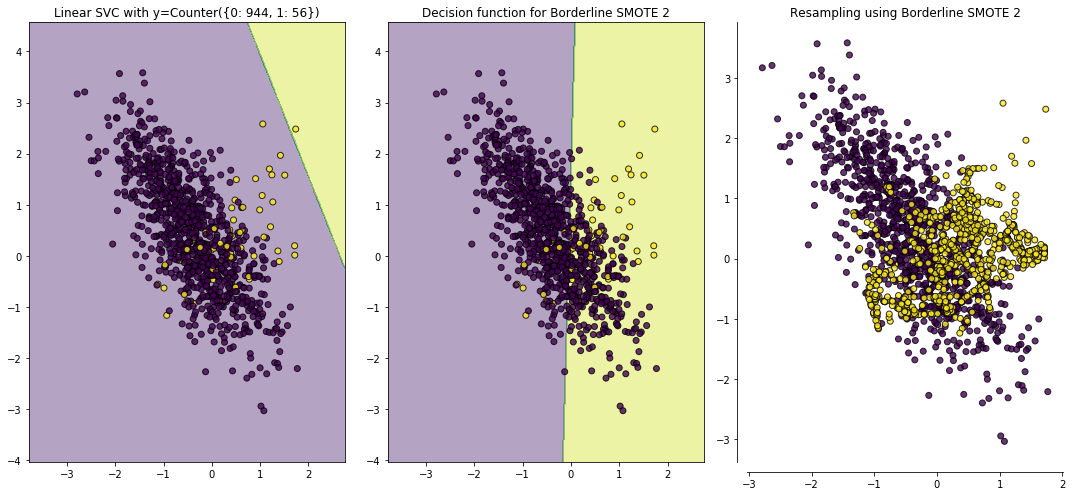

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(BorderlineSMOTE(random_state=0, kind='borderline-2'), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for Borderline SMOTE 2')

plot_resampling(X, y, BorderlineSMOTE(random_state=0, kind='borderline-2'), ax3)
ax3.set_title('Resampling using Borderline SMOTE 2')
fig.tight_layout()

In [16]:
con, cr, prec, rec = confusion('Borderline SMOTE 2', resultsDF, pipe.predict(X), y)
resultsDF

[[656 288]
 [ 13  43]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.69      0.77      0.81      0.73      0.53       944
          1       0.13      0.77      0.69      0.22      0.73      0.54        56

avg / total       0.93      0.70      0.76      0.78      0.73      0.53      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                   0.944945    1.000000       1.000000    0.017857
Random Over Sampling       0.977305    0.729873       0.135593    0.714286
SMOTE                      0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1         0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2         0.980568    0.694915       0.129909    0.767857

## SVMSMOTE
SVM-SMOTE focuses on generating new minority class instances near borderlines with SVM so as to help establish boundary between classes.
https://medium.com/vclab/tackling-class-imbalance-with-svm-smote-efa41ec3de5f

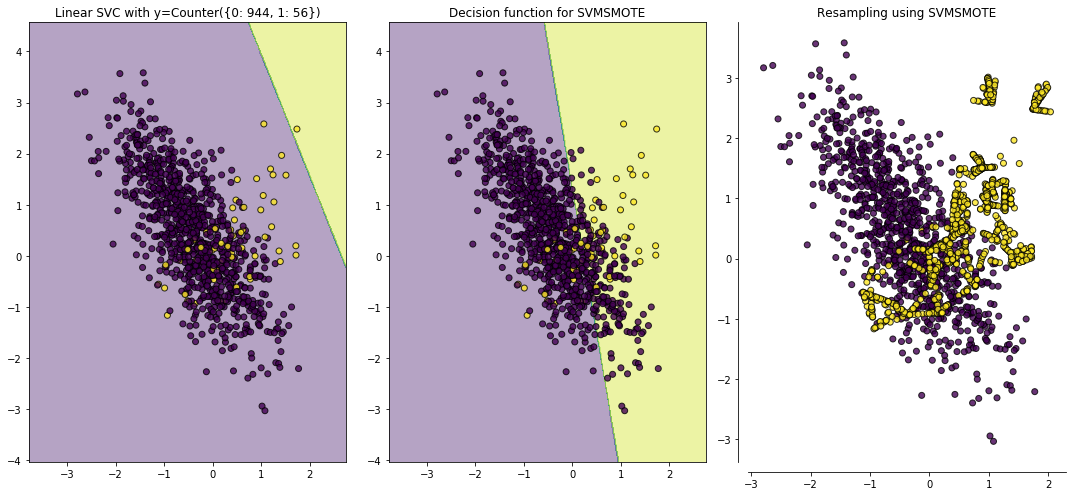

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(SVMSMOTE(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for SVMSMOTE')

plot_resampling(X, y, SVMSMOTE(), ax3)
ax3.set_title('Resampling using SVMSMOTE')
fig.tight_layout()

In [18]:
con, cr, prec, rec = confusion('SVMSMOTE', resultsDF, pipe.predict(X), y)
resultsDF

[[763 181]
 [ 23  33]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.81      0.59      0.88      0.69      0.49       944
          1       0.15      0.59      0.81      0.24      0.69      0.47        56

avg / total       0.93      0.80      0.60      0.85      0.69      0.49      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                   0.944945    1.000000       1.000000    0.017857
Random Over Sampling       0.977305    0.729873       0.135593    0.714286
SMOTE                      0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1         0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2         0.980568    0.694915       0.129909    0.767857
SVMSMOTE                   0.970738    0.808263       0.154206    0.589286

## ADASYN
"SMOTE and ADASYN generate new samples in by interpolation. However, the samples used to interpolate/generate new synthetic samples differ. In fact, ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. Therefore, the decision function found during training will be different among the algorithms." https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#cbhk2002

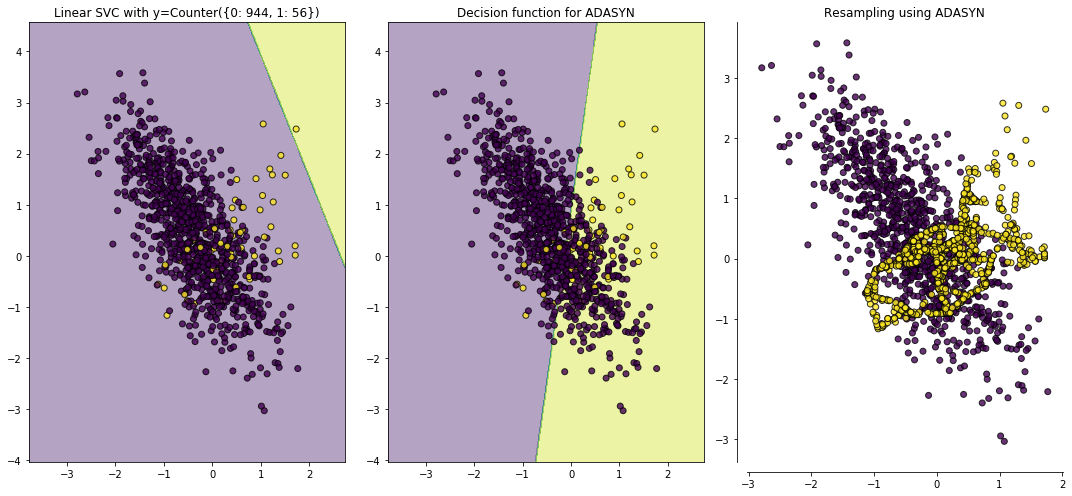

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(ADASYN(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for ADASYN')

plot_resampling(X, y, ADASYN(), ax3)
ax3.set_title('Resampling using ADASYN')
fig.tight_layout()

In [20]:
con, cr, prec, rec = confusion('ADASYN', resultsDF, pipe.predict(X), y)
resultsDF

[[616 328]
 [ 13  43]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.65      0.77      0.78      0.71      0.50       944
          1       0.12      0.77      0.65      0.20      0.71      0.51        56

avg / total       0.93      0.66      0.76      0.75      0.71      0.50      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                   0.944945    1.000000       1.000000    0.017857
Random Over Sampling       0.977305    0.729873       0.135593    0.714286
SMOTE                      0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1         0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2         0.980568    0.694915       0.129909    0.767857
SVMSMOTE                   0.970738    0.808263       0.154206    0.589286
ADASYN                     0.979332    0.652542       0.115903    0.767857

# Under Sampling Techniques
Achieve balance by reducing the number of majority classes datapoints which reduces the imbalance ratio.

## Random Under Sampling

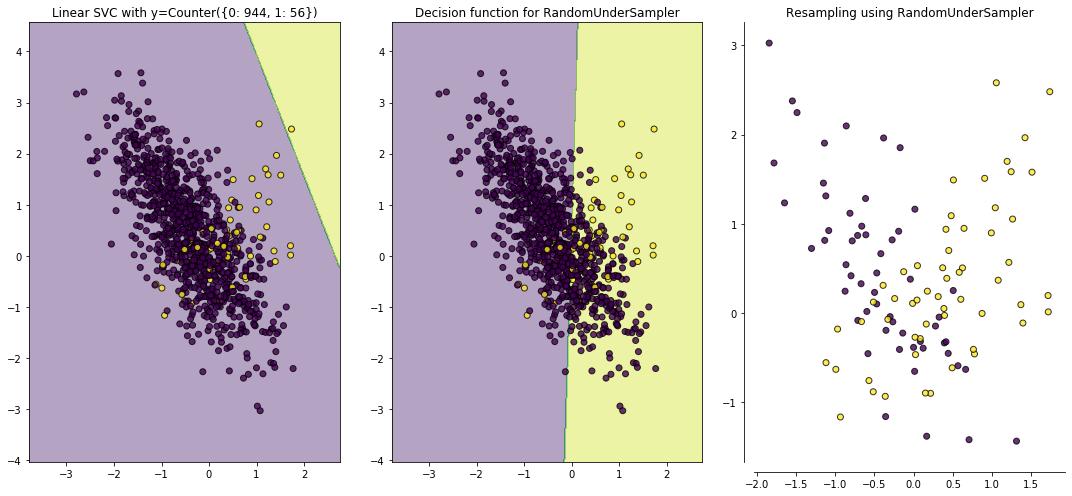

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(RandomUnderSampler(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for RandomUnderSampler')

plot_resampling(X, y, RandomUnderSampler(random_state=0), ax3)
ax3.set_title('Resampling using RandomUnderSampler')
fig.tight_layout()

In [22]:
con, cr, prec, rec = confusion('Random Under Sampling', resultsDF, pipe.predict(X), y)
resultsDF

[[667 277]
 [ 14  42]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.71      0.75      0.82      0.73      0.53       944
          1       0.13      0.75      0.71      0.22      0.73      0.53        56

avg / total       0.93      0.71      0.75      0.79      0.73      0.53      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                    0.944945    1.000000       1.000000    0.017857
Random Over Sampling        0.977305    0.729873       0.135593    0.714286
SMOTE                       0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1          0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2          0.980568    0.694915       0.129909    0.767857
SVMSMOTE                    0.970738    0.808263       0.154206    0.589286
ADASYN                      0.979332    0.652542       0.115903    0.767857
Random Under Sampling       0.979442    0.706568       0.131661    0.750000

## Tomek Links
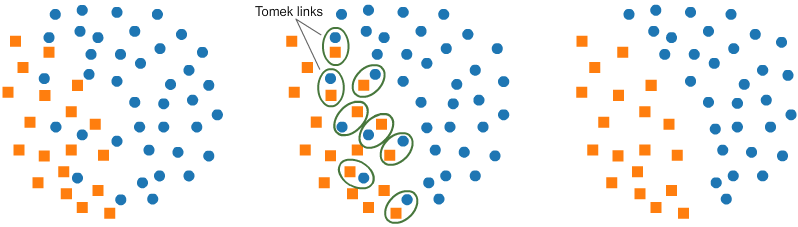

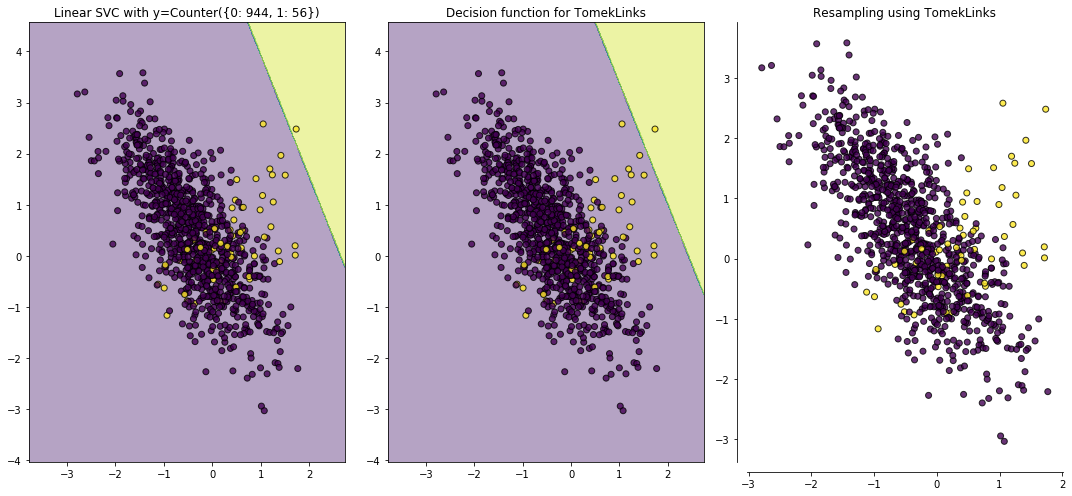

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(TomekLinks(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for TomekLinks')

plot_resampling(X, y, TomekLinks(), ax3)
ax3.set_title('Resampling using TomekLinks')

fig.tight_layout()

In [24]:
con, cr, prec, rec = confusion('TomekLinks', resultsDF, pipe.predict(X), y)
resultsDF

[[944   0]
 [ 55   1]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.02      0.97      0.13      0.02       944
          1       1.00      0.02      1.00      0.04      0.13      0.02        56

avg / total       0.95      0.94      0.07      0.92      0.13      0.02      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                    0.944945    1.000000       1.000000    0.017857
Random Over Sampling        0.977305    0.729873       0.135593    0.714286
SMOTE                       0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1          0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2          0.980568    0.694915       0.129909    0.767857
SVMSMOTE                    0.970738    0.808263       0.154206    0.589286
ADASYN                      0.979332    0.652542       0.115903    0.767857
Random Under Sampling       0.979442    0.706568       0.131661    0.750000
TomekLinks                  0.944945    1.000000       1.000000    0.017857

## Near Miss
Near Miss algorithms implement some heuristic rules in order to select samples. 
* NearMiss-1 Samples from the majority class where the average distance of the k nearest samples of the minority class is the smallest. 
* NearMiss-2 Samples from the majority class where the average distance to the farthest samples of the minority class is the smallest. 
* NearMiss-3 2-step algorithm: 
 * For each minority sample, find M nearest-neighbors will be kept  
 * The majority samples kept are those where the average distance to the k nearest neighbors is the largest

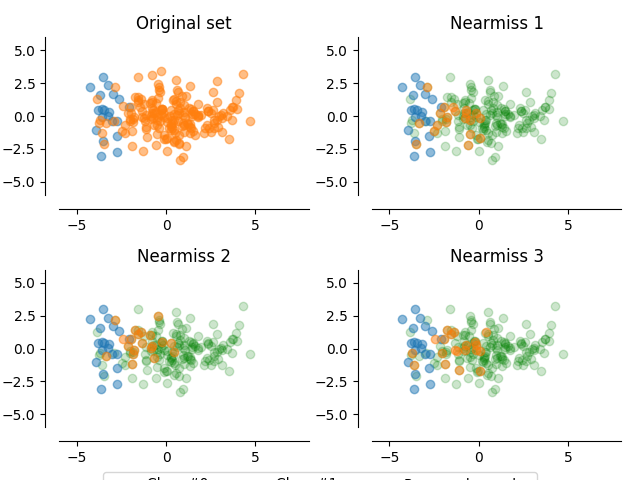

### NearMiss-1

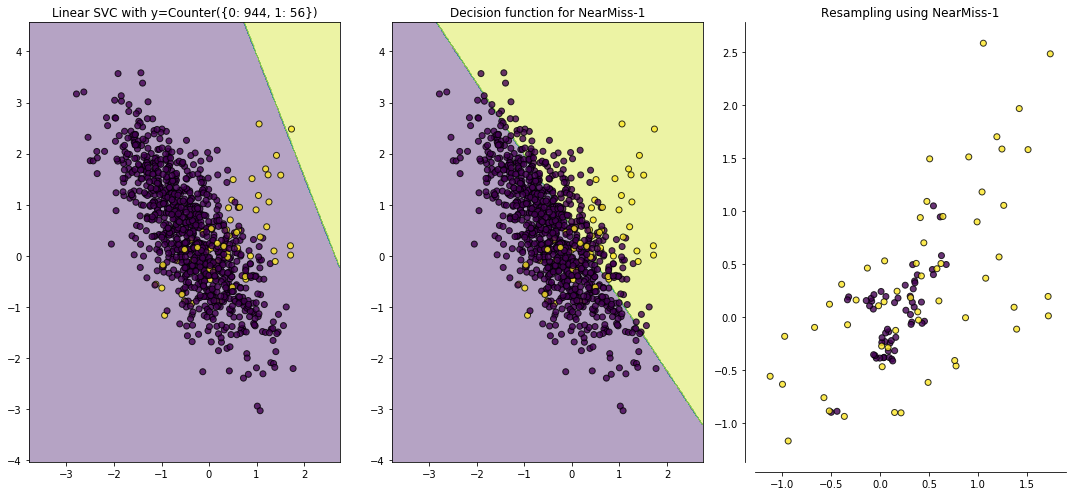

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(NearMiss(version=1), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for NearMiss-1')

plot_resampling(X, y,  NearMiss(version=1), ax3)
ax3.set_title('Resampling using NearMiss-1')
fig.tight_layout()

In [26]:
con, cr, prec, rec = confusion('NearMiss-1', resultsDF, pipe.predict(X), y)
resultsDF

[[770 174]
 [ 24  32]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.82      0.57      0.89      0.68      0.48       944
          1       0.16      0.57      0.82      0.24      0.68      0.45        56

avg / total       0.92      0.80      0.59      0.85      0.68      0.48      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                    0.944945    1.000000       1.000000    0.017857
Random Over Sampling        0.977305    0.729873       0.135593    0.714286
SMOTE                       0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1          0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2          0.980568    0.694915       0.129909    0.767857
SVMSMOTE                    0.970738    0.808263       0.154206    0.589286
ADASYN                      0.979332    0.652542       0.115903    0.767857
Random Under Sampling       0.979442    0.706568       0.131661    0.750000
TomekLinks                  0.944945    1.000000       1.000000    0.017857
NearMiss-1                  0.969773    0.815678       0.155340    0.571429

### NearMiss-2

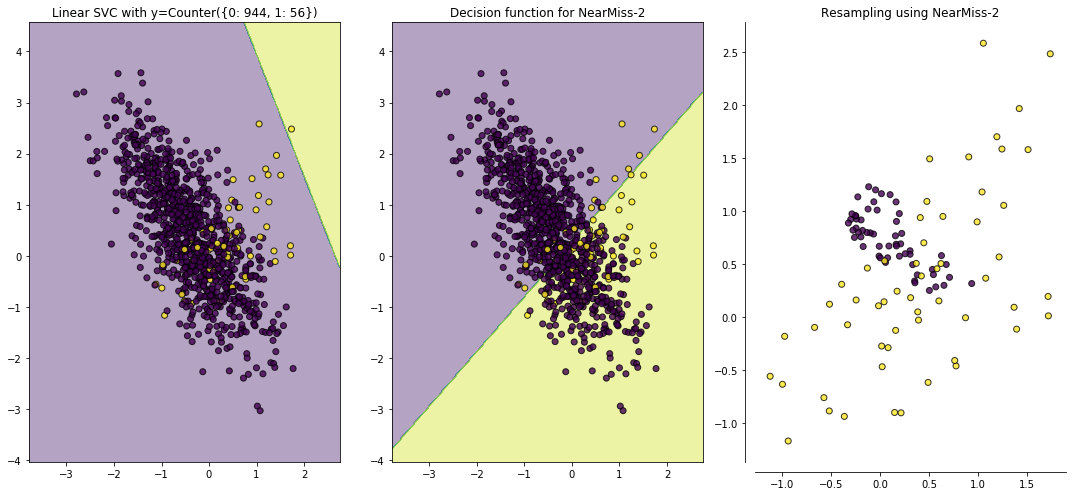

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(NearMiss(version=2), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for NearMiss-2')

plot_resampling(X, y, NearMiss(version=2), ax3)
ax3.set_title('Resampling using NearMiss-2')
fig.tight_layout()

In [28]:
con, cr, prec, rec = confusion('NearMiss-2', resultsDF, pipe.predict(X), y)
resultsDF

[[591 353]
 [ 18  38]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.63      0.68      0.76      0.65      0.42       944
          1       0.10      0.68      0.63      0.17      0.65      0.43        56

avg / total       0.92      0.63      0.68      0.73      0.65      0.42      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                    0.944945    1.000000       1.000000    0.017857
Random Over Sampling        0.977305    0.729873       0.135593    0.714286
SMOTE                       0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1          0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2          0.980568    0.694915       0.129909    0.767857
SVMSMOTE                    0.970738    0.808263       0.154206    0.589286
ADASYN                      0.979332    0.652542       0.115903    0.767857
Random Under Sampling       0.979442    0.706568       0.131661    0.750000
TomekLinks                  0.944945    1.000000       1.000000    0.017857
NearMiss-1                  0.969773    0.815678       0.155340    0.571429
NearMiss-2                  0.970443    0.626059       0.097187    0.678571

### NearMiss-3

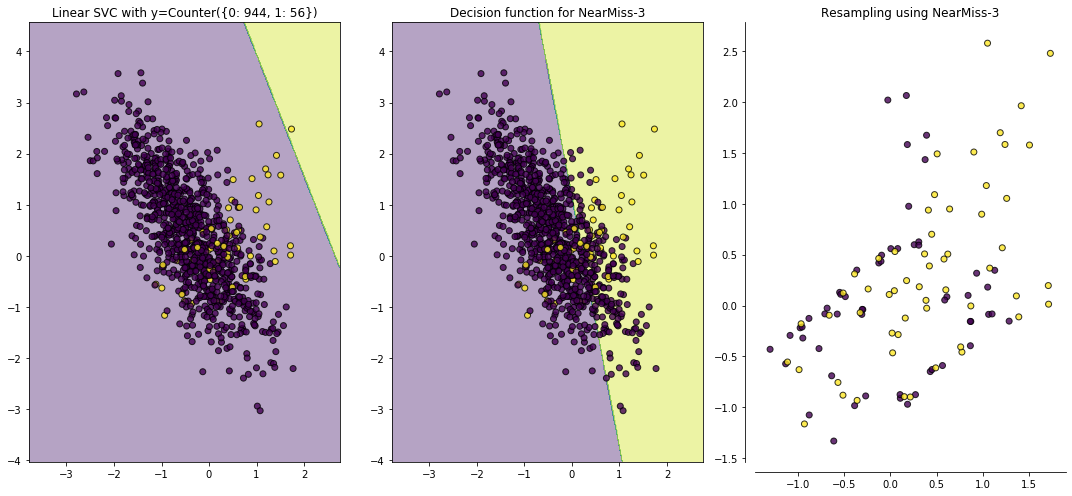

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(NearMiss(version=3), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for NearMiss-3')

plot_resampling(X, y, NearMiss(version=3), ax3)
ax3.set_title('Resampling using NearMiss-3')
fig.tight_layout()

In [30]:
con, cr, prec, rec = confusion('NearMiss-3', resultsDF, pipe.predict(X), y)
resultsDF

[[767 177]
 [ 23  33]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.81      0.59      0.88      0.69      0.49       944
          1       0.16      0.59      0.81      0.25      0.69      0.47        56

avg / total       0.93      0.80      0.60      0.85      0.69      0.49      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                    0.944945    1.000000       1.000000    0.017857
Random Over Sampling        0.977305    0.729873       0.135593    0.714286
SMOTE                       0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1          0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2          0.980568    0.694915       0.129909    0.767857
SVMSMOTE                    0.970738    0.808263       0.154206    0.589286
ADASYN                      0.979332    0.652542       0.115903    0.767857
Random Under Sampling       0.979442    0.706568       0.131661    0.750000
TomekLinks                  0.944945    1.000000       1.000000    0.017857
NearMiss-1                  0.969773    0.815678       0.155340    0.571429
NearMiss-2                  0.970443    0.626059       0.097187    0.678571
NearMiss-3                  0.970886    0.812500       0.157143    0.589286

## Edited Nearest Neighbors
http://cgm.cs.mcgill.ca/~godfried/teaching/projects.pr.98/sergei/project.html
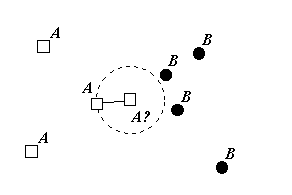

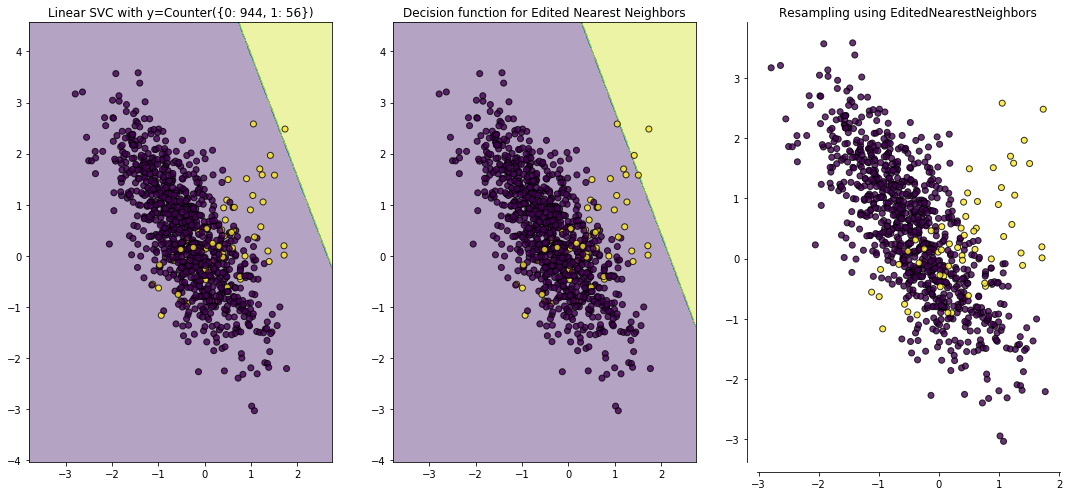

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(EditedNearestNeighbours(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for Edited Nearest Neighbors')

plot_resampling(X, y, EditedNearestNeighbours(), ax3)
ax3.set_title('Resampling using EditedNearestNeighbors')
fig.tight_layout()

In [32]:
con, cr, prec, rec = confusion('Edited Nearest Neighbors', resultsDF, pipe.predict(X), y)
resultsDF

[[944   0]
 [ 54   2]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.04      0.97      0.19      0.04       944
          1       1.00      0.04      1.00      0.07      0.19      0.03        56

avg / total       0.95      0.95      0.09      0.92      0.19      0.04      1000



Maj Precision  Maj Recall  Min Precision  Min Recall
Baseline                       0.944945    1.000000       1.000000    0.017857
Random Over Sampling           0.977305    0.729873       0.135593    0.714286
SMOTE                          0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1             0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2             0.980568    0.694915       0.129909    0.767857
SVMSMOTE                       0.970738    0.808263       0.154206    0.589286
ADASYN                         0.979332    0.652542       0.115903    0.767857
Random Under Sampling          0.979442    0.706568       0.131661    0.750000
TomekLinks                     0.944945    1.000000       1.000000    0.017857
NearMiss-1                     0.969773    0.815678       0.155340    0.571429
NearMiss-2                     0.970443    0.626059       0.097187    0.678571
NearMiss-3                     0.970886    0.812500       0.157143    0.589286
Edited Nearest Neighbors       0.945892    1.000000       1.000000    0.035714

## Repeated Edited Nearest Neighbors

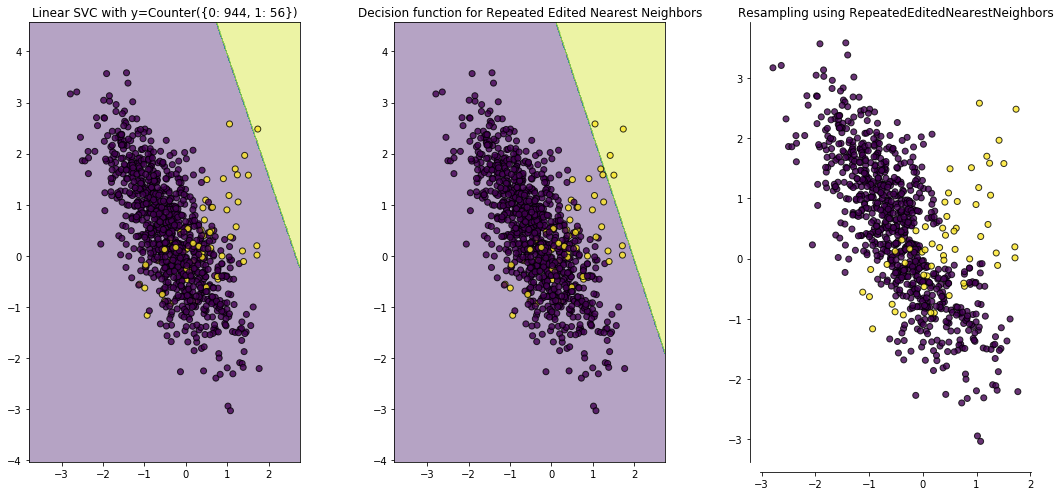

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(RepeatedEditedNearestNeighbours(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for Repeated Edited Nearest Neighbors')

plot_resampling(X, y, RepeatedEditedNearestNeighbours(), ax3)
ax3.set_title('Resampling using RepeatedEditedNearestNeighbors')
fig.tight_layout()

In [34]:
con, cr, prec, rec = confusion('Repeated Edited Nearest Neighbors', resultsDF, pipe.predict(X), y)
resultsDF

[[944   0]
 [ 52   4]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.07      0.97      0.27      0.08       944
          1       1.00      0.07      1.00      0.13      0.27      0.06        56

avg / total       0.95      0.95      0.12      0.93      0.27      0.08      1000



Maj Precision  Maj Recall  Min Precision  \
Baseline                                0.944945    1.000000       1.000000   
Random Over Sampling                    0.977305    0.729873       0.135593   
SMOTE                                   0.980826    0.704449       0.133540   
Borderline SMOTE 1                      0.980626    0.697034       0.130699   
Borderline SMOTE 2                      0.980568    0.694915       0.129909   
SVMSMOTE                                0.970738    0.808263       0.154206   
ADASYN                                  0.979332    0.652542       0.115903   
Random Under Sampling                   0.979442    0.706568       0.131661   
TomekLinks                              0.944945    1.000000       1.000000   
NearMiss-1                              0.969773    0.815678       0.155340   
NearMiss-2                              0.970443    0.626059       0.097187   
NearMiss-3                              0.970886    0.812500       0.157143   
Edited Nearest Neighbors                0.945892    1.000000       1.000000   
Repeated Edited Nearest Neighbors       0.947791    1.000000       1.000000   

                                   Min Recall  
Baseline                             0.017857  
Random Over Sampling                 0.714286  
SMOTE                                0.767857  
Borderline SMOTE 1                   0.767857  
Borderline SMOTE 2                   0.767857  
SVMSMOTE                             0.589286  
ADASYN                               0.767857  
Random Under Sampling                0.750000  
TomekLinks                           0.017857  
NearMiss-1                           0.571429  
NearMiss-2                           0.678571  
NearMiss-3                           0.589286  
Edited Nearest Neighbors             0.035714  
Repeated Edited Nearest Neighbors    0.071429

## AllKNN

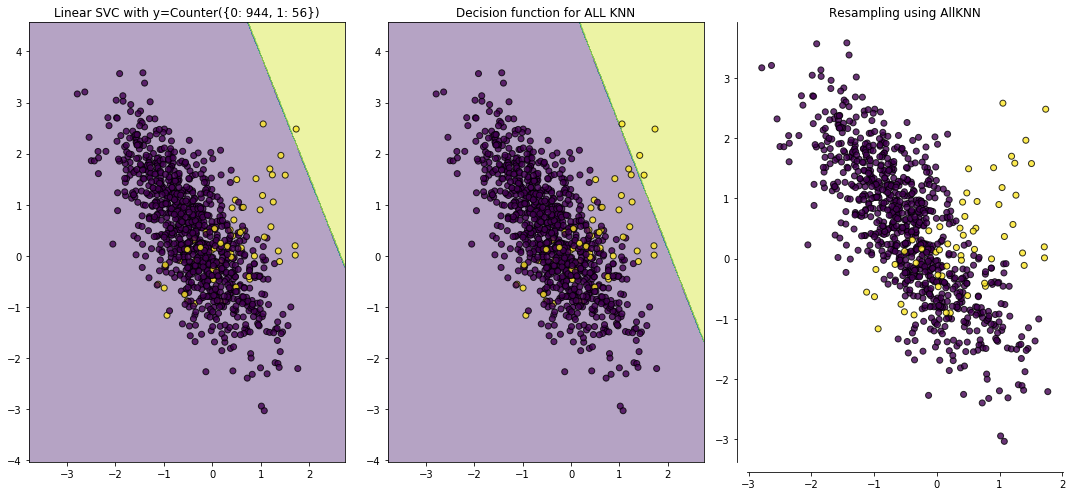

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(AllKNN(allow_minority=True), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for ALL KNN')

plot_resampling(X, y, AllKNN(allow_minority=True), ax3)
ax3.set_title('Resampling using AllKNN')
fig.tight_layout()

In [36]:
con, cr, prec, rec = confusion('AllKNN', resultsDF, pipe.predict(X), y)
resultsDF

[[944   0]
 [ 52   4]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.07      0.97      0.27      0.08       944
          1       1.00      0.07      1.00      0.13      0.27      0.06        56

avg / total       0.95      0.95      0.12      0.93      0.27      0.08      1000



Maj Precision  Maj Recall  Min Precision  \
Baseline                                0.944945    1.000000       1.000000   
Random Over Sampling                    0.977305    0.729873       0.135593   
SMOTE                                   0.980826    0.704449       0.133540   
Borderline SMOTE 1                      0.980626    0.697034       0.130699   
Borderline SMOTE 2                      0.980568    0.694915       0.129909   
SVMSMOTE                                0.970738    0.808263       0.154206   
ADASYN                                  0.979332    0.652542       0.115903   
Random Under Sampling                   0.979442    0.706568       0.131661   
TomekLinks                              0.944945    1.000000       1.000000   
NearMiss-1                              0.969773    0.815678       0.155340   
NearMiss-2                              0.970443    0.626059       0.097187   
NearMiss-3                              0.970886    0.812500       0.157143   
Edited Nearest Neighbors                0.945892    1.000000       1.000000   
Repeated Edited Nearest Neighbors       0.947791    1.000000       1.000000   
AllKNN                                  0.947791    1.000000       1.000000   

                                   Min Recall  
Baseline                             0.017857  
Random Over Sampling                 0.714286  
SMOTE                                0.767857  
Borderline SMOTE 1                   0.767857  
Borderline SMOTE 2                   0.767857  
SVMSMOTE                             0.589286  
ADASYN                               0.767857  
Random Under Sampling                0.750000  
TomekLinks                           0.017857  
NearMiss-1                           0.571429  
NearMiss-2                           0.678571  
NearMiss-3                           0.589286  
Edited Nearest Neighbors             0.035714  
Repeated Edited Nearest Neighbors    0.071429  
AllKNN                               0.071429

# Weighting
Some techniques such as XGBoost allow you to scale the weights of the minority class, achieving balance in the weight of all samples rather than in the count of samples.  

# Ensembles

## SMOTE + ENN

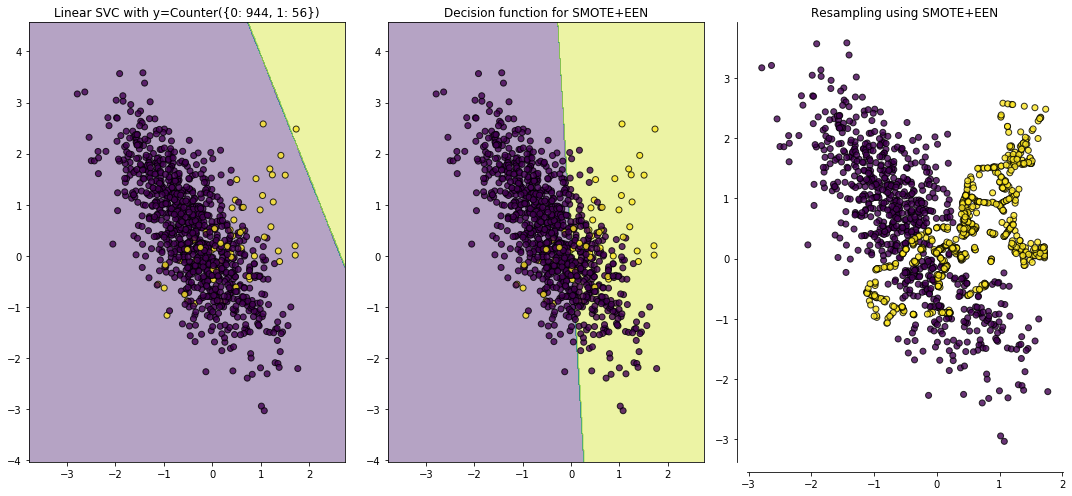

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(SMOTEENN(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for SMOTE+EEN')

plot_resampling(X, y, SMOTEENN(), ax3)
ax3.set_title('Resampling using SMOTE+EEN')
fig.tight_layout()

In [38]:
con, cr, prec, rec = confusion('SMOTE+ENN', resultsDF, pipe.predict(X), y)
resultsDF

[[681 263]
 [ 16  40]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.72      0.71      0.83      0.72      0.52       944
          1       0.13      0.71      0.72      0.22      0.72      0.51        56

avg / total       0.93      0.72      0.71      0.80      0.72      0.52      1000



Maj Precision  Maj Recall  Min Precision  \
Baseline                                0.944945    1.000000       1.000000   
Random Over Sampling                    0.977305    0.729873       0.135593   
SMOTE                                   0.980826    0.704449       0.133540   
Borderline SMOTE 1                      0.980626    0.697034       0.130699   
Borderline SMOTE 2                      0.980568    0.694915       0.129909   
SVMSMOTE                                0.970738    0.808263       0.154206   
ADASYN                                  0.979332    0.652542       0.115903   
Random Under Sampling                   0.979442    0.706568       0.131661   
TomekLinks                              0.944945    1.000000       1.000000   
NearMiss-1                              0.969773    0.815678       0.155340   
NearMiss-2                              0.970443    0.626059       0.097187   
NearMiss-3                              0.970886    0.812500       0.157143   
Edited Nearest Neighbors                0.945892    1.000000       1.000000   
Repeated Edited Nearest Neighbors       0.947791    1.000000       1.000000   
AllKNN                                  0.947791    1.000000       1.000000   
SMOTE+ENN                               0.977044    0.721398       0.132013   

                                   Min Recall  
Baseline                             0.017857  
Random Over Sampling                 0.714286  
SMOTE                                0.767857  
Borderline SMOTE 1                   0.767857  
Borderline SMOTE 2                   0.767857  
SVMSMOTE                             0.589286  
ADASYN                               0.767857  
Random Under Sampling                0.750000  
TomekLinks                           0.017857  
NearMiss-1                           0.571429  
NearMiss-2                           0.678571  
NearMiss-3                           0.589286  
Edited Nearest Neighbors             0.035714  
Repeated Edited Nearest Neighbors    0.071429  
AllKNN                               0.071429  
SMOTE+ENN                            0.714286

## SMOTE + TomekLinks

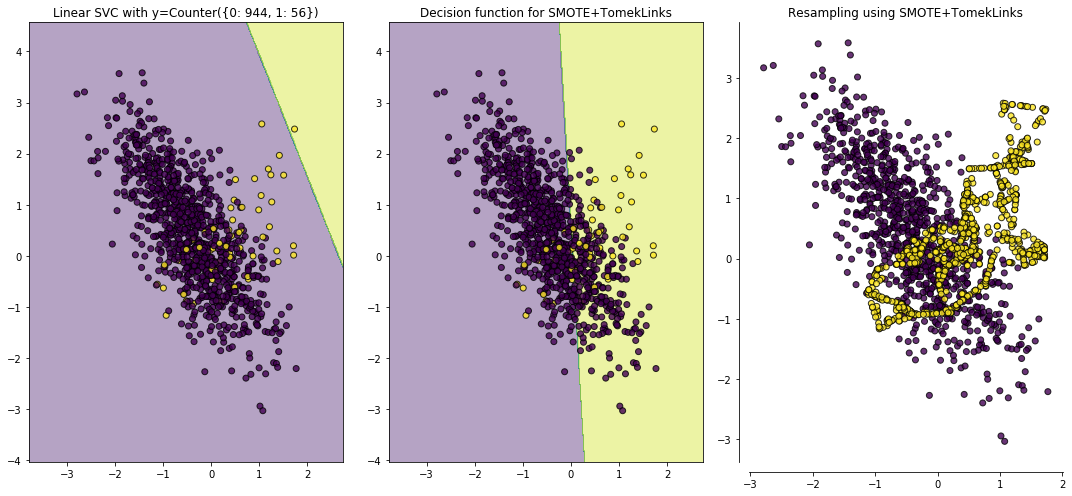

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(SMOTETomek(), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for SMOTE+TomekLinks')

plot_resampling(X, y, SMOTETomek(), ax3)
ax3.set_title('Resampling using SMOTE+TomekLinks')
fig.tight_layout()

In [40]:
con, cr, prec, rec = confusion('SMOTE+TomekLinks', resultsDF, pipe.predict(X), y)
resultsDF

[[691 253]
 [ 16  40]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.73      0.71      0.84      0.72      0.52       944
          1       0.14      0.71      0.73      0.23      0.72      0.52        56

avg / total       0.93      0.73      0.72      0.80      0.72      0.52      1000



Maj Precision  Maj Recall  Min Precision  \
Baseline                                0.944945    1.000000       1.000000   
Random Over Sampling                    0.977305    0.729873       0.135593   
SMOTE                                   0.980826    0.704449       0.133540   
Borderline SMOTE 1                      0.980626    0.697034       0.130699   
Borderline SMOTE 2                      0.980568    0.694915       0.129909   
SVMSMOTE                                0.970738    0.808263       0.154206   
ADASYN                                  0.979332    0.652542       0.115903   
Random Under Sampling                   0.979442    0.706568       0.131661   
TomekLinks                              0.944945    1.000000       1.000000   
NearMiss-1                              0.969773    0.815678       0.155340   
NearMiss-2                              0.970443    0.626059       0.097187   
NearMiss-3                              0.970886    0.812500       0.157143   
Edited Nearest Neighbors                0.945892    1.000000       1.000000   
Repeated Edited Nearest Neighbors       0.947791    1.000000       1.000000   
AllKNN                                  0.947791    1.000000       1.000000   
SMOTE+ENN                               0.977044    0.721398       0.132013   
SMOTE+TomekLinks                        0.977369    0.731992       0.136519   

                                   Min Recall  
Baseline                             0.017857  
Random Over Sampling                 0.714286  
SMOTE                                0.767857  
Borderline SMOTE 1                   0.767857  
Borderline SMOTE 2                   0.767857  
SVMSMOTE                             0.589286  
ADASYN                               0.767857  
Random Under Sampling                0.750000  
TomekLinks                           0.017857  
NearMiss-1                           0.571429  
NearMiss-2                           0.678571  
NearMiss-3                           0.589286  
Edited Nearest Neighbors             0.035714  
Repeated Edited Nearest Neighbors    0.071429  
AllKNN                               0.071429  
SMOTE+ENN                            0.714286  
SMOTE+TomekLinks                     0.714286

# Metrics

## Best Precision on Majority Class

In [41]:
resultsDF.sort_values('Maj Precision', ascending=False).head(3)

Maj Precision  Maj Recall  Min Precision  Min Recall
SMOTE                    0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1       0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2       0.980568    0.694915       0.129909    0.767857

## Best Recall on Minority Class

In [42]:
resultsDF.sort_values('Min Recall', ascending=False).head(3)

Maj Precision  Maj Recall  Min Precision  Min Recall
SMOTE                    0.980826    0.704449       0.133540    0.767857
Borderline SMOTE 1       0.980626    0.697034       0.130699    0.767857
Borderline SMOTE 2       0.980568    0.694915       0.129909    0.767857

## Best Model

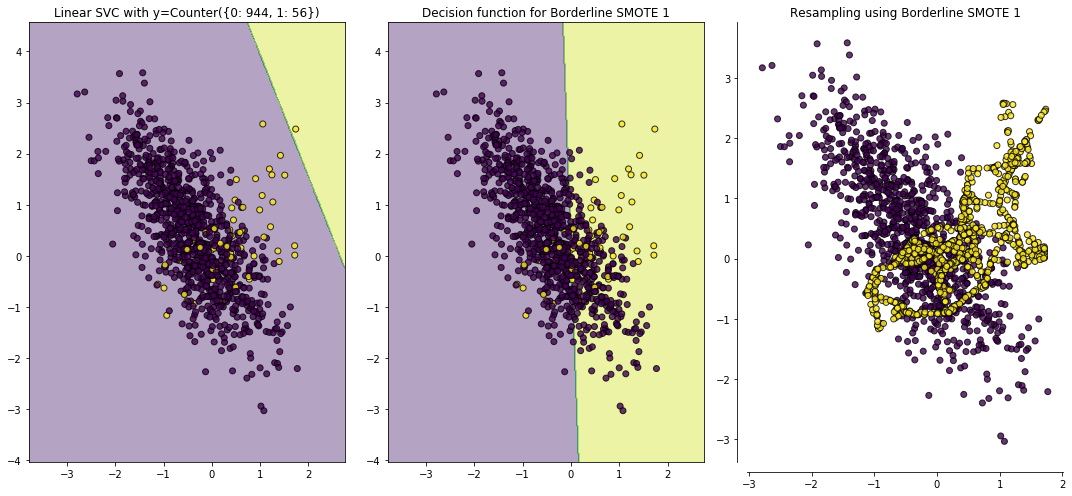

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

pipe = make_pipeline(LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

pipe = make_pipeline(SMOTE(random_state=0), LinearSVC())
pipe.fit(X, y)
plot_decision_function(X, y, pipe, ax2)
ax2.set_title('Decision function for SMOTE')

plot_resampling(X, y, SMOTE(random_state=0), ax3)
ax3.set_title('Resampling using SMOTE')
fig.tight_layout()

## ROC & Precision Recall Curves
"ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets. In both cases the area under the curve (AUC) can be used as a summary of the model performance."
http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/

Practical Guidelines
* To Interpret - We plot our probabiities of being in the majority class
* When we decide what class we choose a threshold
* Usually this threshold is 0.5
* We plot ROC and Precision Recall Curves to explore different thresholds
 * ROC Curve - Tradeoff between True Positive & False Positive 
 * Precision Recall Curve - Tradeoff between True Positive & Positive Predictive Value

Text(0.5, 1.0, 'Precision Recall Curve - AUC: 0.446')

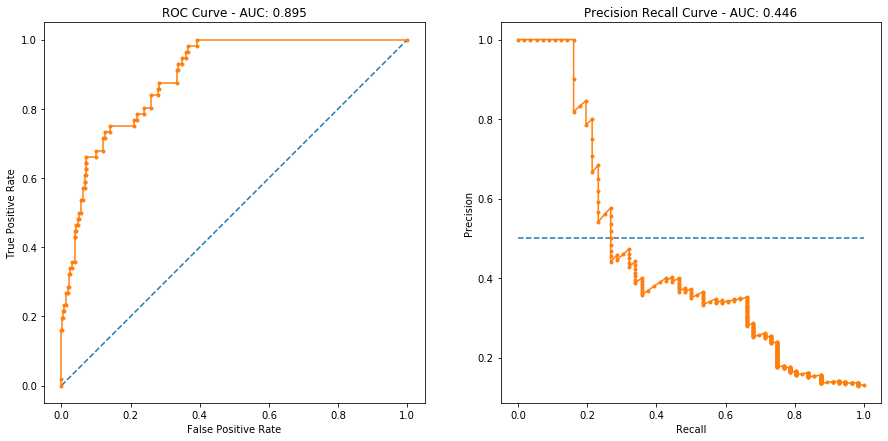

In [52]:
#Generate Probabilities
pipe = make_pipeline(SMOTE(kind='borderline-1'), SVC(probability=True, gamma='auto'))
pipe.fit(X, y)
probs = pipe.predict_proba(X)
probs = probs[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

#Imbalanced ROC Curve
fpr, tpr, thresholds = roc_curve(y, probs)
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.plot(fpr, tpr, marker='.')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - AUC: %.3f' % roc_auc_score(y, probs))

#Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y, probs)
ax2.plot([0, 1], [0.5, 0.5], linestyle='--')
ax2.plot(recall, precision, marker='.')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve - AUC: %.3f' %  auc(recall, precision))

# Conclusions
* Imbalanced Data is Everywhere (Fraud, Waivers & Cancellations)
* Imbalanced Datasets can lead to poor predictions (hard to find boundaries)
* Imbalanced-Learning package is easy to use and rich on techniques
* Choose the right metrics (Precision & Recall)
* Accuracy is usually not very informative (consider Geo Mean or Index Balanced metrics)
* No Free Lunch

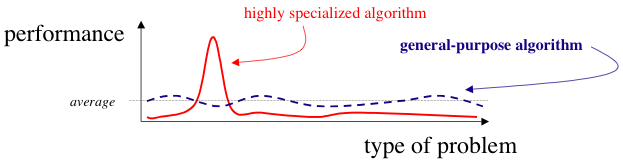